In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy, time
from core.rl_utils import Replay_Buffer, quantize
from core.envs.home_battery import Home_Battery

## The Home_Battery() environment

The Home_Battery() environment emulates the hourly energy demand of a residential house, as well as the dynamics of an energy storage system (battery) that is integrated to the aforementioned house. In this environment, the cost of energy follows a time-of-use (TOU) pricing scheme where the price per kilowatt-hour (kWh) depends on the hour of the day at which the energy is purchased from the grid. **The goal is to design an intelligent energy management system (EMS) to reduce the monthly energy bill of the residential house**. For instance, an intelligent EMS might charge the battery at hours when the energy is less expensive, and then, during more expensive hours, discharge the battery to fulfil the energy demand of the house. Moreover, the EMS might also sell energy back to the grid, so that the energy bill can be further reduced (the selling price is the same as the buying TOU price).

To illustrate the environment, the following cell depicts a 24h sample of the energy demand profile of the house, as well as the TOU prices along the day. It is worth mentioning that the energy demand follows a unknown probability distribution over the day, while the TOU prices are fixed as shown for all days.

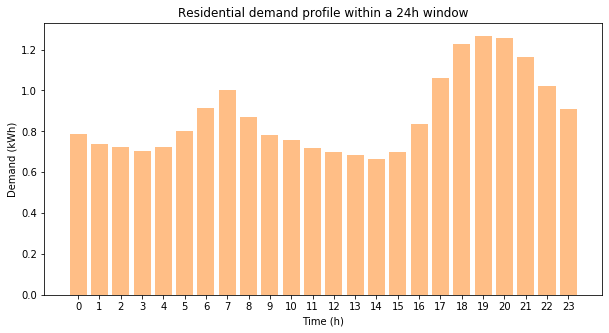

Hour: 0 --------> TOU price [$/kWh]: 0.219
Hour: 1 --------> TOU price [$/kWh]: 0.219
Hour: 2 --------> TOU price [$/kWh]: 0.219
Hour: 3 --------> TOU price [$/kWh]: 0.219
Hour: 4 --------> TOU price [$/kWh]: 0.219
Hour: 5 --------> TOU price [$/kWh]: 0.219
Hour: 6 --------> TOU price [$/kWh]: 0.219
Hour: 7 --------> TOU price [$/kWh]: 0.219
Hour: 8 --------> TOU price [$/kWh]: 0.219
Hour: 9 --------> TOU price [$/kWh]: 0.246
Hour: 10 -------> TOU price [$/kWh]: 0.246
Hour: 11 -------> TOU price [$/kWh]: 0.246
Hour: 12 -------> TOU price [$/kWh]: 0.27
Hour: 13 -------> TOU price [$/kWh]: 0.27
Hour: 14 -------> TOU price [$/kWh]: 0.27
Hour: 15 -------> TOU price [$/kWh]: 0.27
Hour: 16 -------> TOU price [$/kWh]: 0.27
Hour: 17 -------> TOU price [$/kWh]: 0.27
Hour: 18 -------> TOU price [$/kWh]: 0.246
Hour: 19 -------> TOU price [$/kWh]: 0.246
Hour: 20 -------> TOU price [$/kWh]: 0.246
Hour: 21 -------> TOU price [$/kWh]: 0.246
Hour: 22 -------> TOU price [$/kWh]: 0.219
Hour: 23 ------->

In [2]:
env = Home_Battery()
env.show_demand_profile()
tou_prices = env.get_time_of_use_prices() # Time of use prices are in dollars

for i, p in enumerate(tou_prices):
    arrow = '-------->' if i < 10 else '------->'
    print('Hour:', i, arrow, 'TOU price [$/kWh]:', p)

## Using the Home_Battery() environment

### State definition:
The **state** of the environment is returned whenever the methods **env.reset()**, **env.observe()**, or **env.step()** are called. The **state** is represented as an array of two elements:

\begin{equation*}
    \text{state} = [x_1, x_2]
\end{equation*}

where $x_1$ is a normalized value indicating the current time-slot of the day, and $x_2$ is the normalized current state of charge (SOC) of the battery. In both cases, the normalizations are performed so that $x_1, x_2 \in [-1, 1]$. Furthermore, this environment does not have a **terminal state**.

### Action definition:
The Home_Battery() environment receives one discrete action with $4$ possible values: $[0, 1, 2, 3]$, i.e., the **action** must be an scalar within the aforementioned range. The **action** has to be provided as input to the **env.step()** method at the begining of each time-slot, and it corresponds to the **action** that the EMS is going to perform during the whole time-slot. The meaining of the **action** value is as follows:
* $\text{action} = 0$ $\longrightarrow$ **Buy:** the EMS buys energy from the grid to fulfil the (unkown) demand of the current time-slot.
* $\text{action} = 1$ $\longrightarrow$ **Charge:** the same as the **Buy** action, but the EMS also buys an additional unit of energy (i.e., $1$kWh) to charge the battery.
* $\text{action} = 2$ $\longrightarrow$ **Discharge:** the EMS uses all or part of the battery's stored energy to fulfil the (unknown) demand of the current time-slot. Moreover, if necessary, the EMS buys additional energy from the grid to fulfil the energy demand.
* $\text{action} = 2$ $\longrightarrow$ **Sell:** the same as the **Discharge** action, but the EMS also sells one additional unit of energy (i.e., $1$kWh) to the grid.

It is worth mentioning that the aforementioned actions have some restrictions, i.e., not all actions can be executed at every **state**. More precisely:
* The actions **Discharge** and **Sell** cannot be executed if the battery's SOC is under a given guard level.
* The action **Sell** cannot be performed if the battery's SOC is less than one unit of energy (i.e., $1$kWh).
* The action **Charge** cannot be executed if the battery's SOC is above a given guard level.

To ease the use of the environent, at any **state** the method **env.get_available_actions()** returns a list with the indices of the actions that can be executed at that **state**.

### State transition:
The **state transition**, i.e., $x_k\rightarrow x_{k+1}$, is performed by the **env.step()** method if an **action** is provided (such transition is performed by the environment class). Moreover, the **action restrictions** are considered within the environment at every **state transition**. Nevertheless, it might be convenient to consider them at the EMS level as well.

### Reward definition:
Given that the goal is to reduce the monthly energy bill of the residential house, the **reward** of the environment penalizes the energy expenses and rewards the earnings (of selling energy). The **reward** variable is returned by the **env.step()** method, and it is implemented as a function of the energy exchange between the EMS and the grid, and the TOU prices. More precisely, the **reward** at time-slot $k$ is given by:

\begin{equation*}
    \text{reward} = -\rho_1 * \text{EX}_k * e^{\beta}
\end{equation*}
with
\begin{equation*}
    \beta = \rho_2 * (p_k - p_{max})
\end{equation*}

where $\text{EX}_k$ is the energy exchage that goes from the grid to the EMS at time-slot $k$ ($\text{EX}_k$ is negative when the energy goes from the EMS to the grid, i.e., when selling); $p_k$ is the TOU price at time-slot $k$; $p_{max}$ is the maximum TOU price over all time-slots; and $\rho_1, \rho_2\in\mathbb{R}_{>0}$ are tuneable parameters to increase/reduce the scale and value of the reward (e.g., note that $\rho_2$ can increase or decrease the difference between the TOU prices). The environment uses $\rho_1=4$ and $\rho_2=30$ by default. However, these parameters can be changed in the creation of the environment's instance:

**env = Home_Battery(rho_1 = a, rho_2 = b)**.

To illustrate the use of the environment and clarify the aforementioned points, the following cell depicts the implementation of a tabular version of the Q-learning algorithm applied to the Home_Battery() environment.

## Tabular Q-learning

Total training time: 108.56 seconds


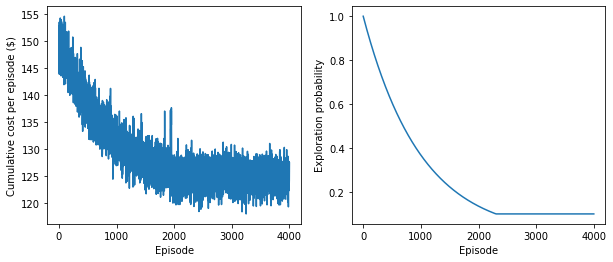

In [3]:
np.random.seed(123) # For reproducibility

env = Home_Battery(rho1=4, rho2=30)    # Create an instance of the environment

num_time_levels = 10         # Number of discretization levels for the time (only for tabular Q-learning)
num_battery_soc_levels = 10  # Number of discretization levels for the SOC (only for tabular Q-learning)

num_actions = env.num_actions           # Number of actions
Q_table = np.zeros((num_time_levels, num_battery_soc_levels, num_actions)) # Initial Q-table

num_episodes = 4000                     # Number of training episodes
num_steps = 30*24                       # Number of steps per episode
epsilon = 1.0                           # Initial exploration probability
alpha = 0.02                            # Learning rate
gamma = 0.95                            # Discount factor

cumulative_cost_log = []                # Empty list to log cumulative energy cost
epsilon_log = []                        # Empty list to log exploration probabilities

initial_time = time.time()              # Record the initial time

for e in range(num_episodes):           # Loop over episodes
    state = env.reset()                 # Reset environment
    
    # Discretize the state (only for tabular Q-learning)
    x1 = quantize(state[0], num_levels=num_time_levels)
    x2 = quantize(state[1], num_levels=num_battery_soc_levels)
        
    for s in range(num_steps):                          # Loop over steps
        available_actions = env.get_available_actions() # Get available actions at current state
        
        if(np.random.random() <= epsilon):  # espilon-greedy policy considering available actions
            action = available_actions[np.random.randint(len(available_actions))]
        else:
            action = np.argmax(Q_table[x1, x2, available_actions])
        
        next_state, reward, _ = env.step(action)     # Execute selected action
        
        # Discretize the next state (only for tabular Q-learning)
        next_x1 = quantize(next_state[0], num_levels=num_time_levels)
        next_x2 = quantize(next_state[1], num_levels=num_battery_soc_levels)
        
        # Q-table update
        next_available_actions = env.get_available_actions()
        target = reward + gamma * np.max(Q_table[next_x1, next_x2, next_available_actions])        
        Q_table[x1, x2, action] += alpha * (target - Q_table[x1, x2, action])
        
        x1 = next_x1 # State update
        x2 = next_x2 # State update
        
    cumulative_cost_log.append(env.get_cumulative_energy_cost()) # Save cumulative cost of episode
    
    epsilon_log.append(epsilon)      # Append exploration probability 
    epsilon = np.maximum(0.999 * epsilon, 0.1)   # Exploration decay (clipped)
    
total_training_time = time.time() - initial_time # Record total training time
    
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(cumulative_cost_log)
plt.xlabel('Episode')
plt.ylabel('Cumulative cost per episode ($)')

plt.subplot(122)
plt.plot(epsilon_log)
plt.xlabel('Episode')
plt.ylabel('Exploration probability');

print('Total training time:', np.round(total_training_time, 2), 'seconds')

## Testing the tabular Q-learning

Now that the tabular Q-learning agent has been trained, we can evaluate the learned policy running it during a month at the residential house.

For comparison purposes, we compare it against the **always Buy** policy.

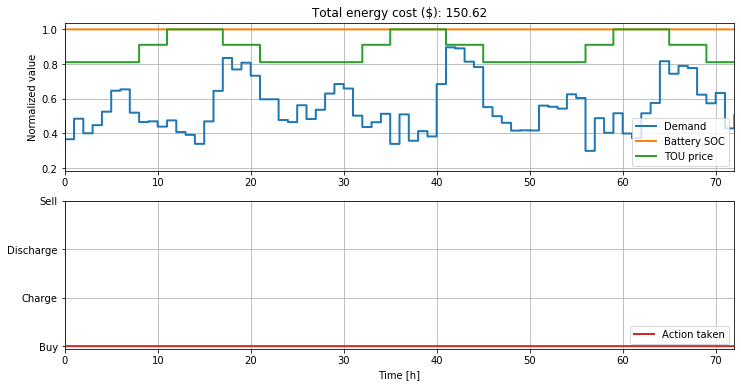

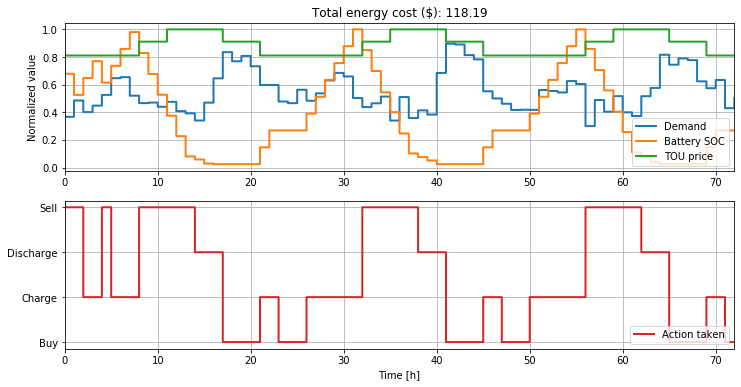

In [4]:
# ==============================
# ALWAYS BUY POLICY 
# ==============================
np.random.seed(100)  # So that the comparison is fair

env = Home_Battery() # Create a new instance of the environment

env.enable_data_recorder() # To record the environment's data

state = env.reset()        # Reset the environment
for day in range(30):      # Loop over 30 days
    for hour in range(24): # Loop over 24 hours
        _, _, _ = env.step(0) # Take the Buy action
        
env.show_recorded_data() # Display results (3 days window)


# ==============================
# LEARNED POLICY 
# ==============================
np.random.seed(100) # So that the comparison is fair

env = Home_Battery()  # Create a new instance of the environment

env.enable_data_recorder() # To record the environment's data

state = env.reset()        # Reset the environment
for day in range(30):      # Loop over 30 days
    for hour in range(24): # Loop over 24 hours
        # Discretize the state (only for tabular Q-learning)
        x1 = quantize(state[0], num_levels=num_time_levels)
        x2 = quantize(state[1], num_levels=num_battery_soc_levels)
        
        available_actions = env.get_available_actions() # Get available actions
        
        # Take the best available action according to the learned policy
        action = np.argmax(Q_table[x1, x2, available_actions]) 
        state, _, _ = env.step(action)
        
env.show_recorded_data() # Display results (3 days window)

# Exercise:

#### Implement an EMS using Q-learning with a neural network approximator to outperform the given tabular Q-learning agent.

### Some tips:
* Start with a neural network with one single hidden layer and adjust the number of neurons gradually. If you want, you can then try neural networks with more hidden layers (however, great results can be obtained with one single hidden layer with few neurons).
* In contrast with the tabular version, for the update of the neural networks you may not consider the next_available_actions (this is simply to ease the implementation, and great results can still be obtained with this simplification).
* Use the vectorized implementation of Q-learning provided in the notebook: Q-learning with neural networks.
* Main parameters to play with: number of neurons, activation functions, learning rates, number of training episodes, number of steps per episode, update frequency per episode, batch size.
* **THE TRAINING TIME SHOULD NOT BE EXCESSIVELY LONG**. With appropiate hyperparameters, it takes around $3$ minutes to complete the training and outperform the tabular version (running the notebook on binder).

In [ ]:
# Implement the Neural Network class

In [ ]:
# Implement the training procedure for Q-learning with a neural network approximator
# The neural network instance should be named net (so that the code of the next cell works)

In [ ]:
# ===============================
# LEARNED POLICY (NEURAL NETWORK)
# ===============================
np.random.seed(100) # So that the comparison is fair

env = Home_Battery()  # Create a new instance of the environment

env.enable_data_recorder() # To record the environment's data

state = env.reset()        # Reset the environment
for day in range(30):      # Loop over 30 days
    for hour in range(24): # Loop over 24 hours
        available_actions = env.get_available_actions() # Get available actions
        
        # Take the best available action according to the learned policy
        Q_values = net.forward_pass(state)
        action = available_actions[np.argmax(Q_values[available_actions, :])]
        state, _, _ = env.step(action)
        
env.show_recorded_data() # Display results (3 days window)